In [1]:
using Pkg
using Revise 

# Load package environment.
Pkg.activate(".")
Pkg.instantiate()

Activating environment at `~/.julia/dev/ConvCNPs/Project.toml`


In [2]:
using Flux
using ConvCNPs
using Random
using Stheno
using StatsBase
using Distributions
using Plots

In [3]:
# Define structure for GP data generator
struct GPDataGenerator
    gp::GP
    batch_size::Integer
    x_dist::Distribution
    max_train_points::Integer
    max_test_points::Integer
end

In [4]:
# Constructor for the GP
# Required args: stheno kernel to define the GP
function GPDataGenerator(
    k::Stheno.Kernel;
    batch_size::Integer=16,
    x_dist::Distribution=Uniform(-2., 2.),
    max_train_points::Integer=10,
    max_test_points::Integer=10,
)
    gp = GP(k, GPC())
    return GPDataGenerator(
        gp,
        batch_size,
        x_dist,
        max_train_points,
        max_test_points        
    )
end

GPDataGenerator

In [5]:
# Preamble to data-generating procedure
noise = 1e-10
_batch_data(x) = cat(x..., dims=3) 

# Function generate data from a GP
function (generator::GPDataGenerator)(num_batches::Integer)
    epoch = []
    for batch in 1:num_batches
        num_context = rand(3:generator.max_train_points)
        num_target = rand(3:generator.max_test_points)
        push!(epoch, get_batch(generator, num_context, num_target))
    end
    return epoch
end   

# Helper function to generate a batch of tasks
function get_batch(
        generator::GPDataGenerator,
        num_context::Integer,
        num_target::Integer
    )
    inputs, outputs = [], [] 
    x_context, y_context = [], []
    x_target, y_target = [], []
    for i in 1:generator.batch_size
        # Generate task data
        x = rand(generator.x_dist, num_context + num_target)
        y = rand(generator.gp(x, noise))
        # Pull out context and target data
        push!(inputs, x)
        push!(outputs, y)
        push!(x_context, x[1:num_context])
        push!(y_context, y[1:num_context])
        push!(x_target, x[num_context+1:end])
        push!(y_target, y[num_context+1:end])
    end
    return (
        x_context=_batch_data(x_context), 
        y_context=_batch_data(y_context), 
        x_target=_batch_data(x_target),
        y_target=_batch_data(y_target)
    )
end

get_batch (generic function with 1 method)

In [68]:
# Set seed
rng = MersenneTwister(123456);

# Define Kernel hyper-parameters
l = 0.25;
σ² = 1.3;
k = stretch(matern52(), 1 / l);

# Instantiate data generator
data_gen = GPDataGenerator(k, max_train_points=50, max_test_points=50);

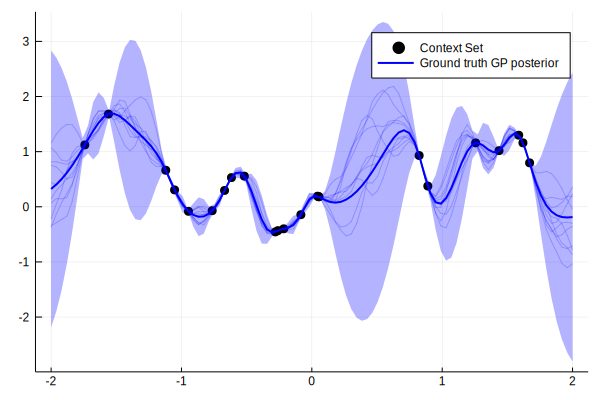

In [69]:
# Grab and plot a task from the GP
epoch = data_gen(16);
batches = [((d.x_context, d.y_context, d.x_target), d.y_target) for d in epoch];

# Pull out a single task to plot
x_context, y_context, x_target = batches[1][1];
xt = LinRange(-2., 2., 100);

# Compute GP posterior
fx = data_gen.gp(x_context[:, 1, 1], noise)
f_posterior = data_gen.gp | Obs(fx, y_context[:, 1, 1])

# Lazy: using Stheno's baked in plotting mechanism
plt = plot();
scatter!(plt, x_context[:, 1, 1], y_context[:, 1, 1], color=:black, label="Context Set")
plot!(plt, f_posterior(xt); samples=10, label="Ground truth GP posterior", color=:blue);
display(plt);

In [70]:
# Softplus function
softplus(x) = log.(exp.(1 .+ x))

function gaussian_loglikelihood(x::AbstractArray, μ::AbstractArray, σ::AbstractArray)
    d = size(x)[1]
    const_term = 0.5 * d * log(2 * π)
    log_det_term = sum(log.(σ), dims=1)
    dx = x .- μ
    norm_term = 0.5 .* sum(σ.^(-2) .* dx .* dx, dims=1)
    return -(const_term .+ log_det_term .+ norm_term)
end

function loss(x::Tuple, y::AbstractArray)
    # Pass data through model
    y_ = convcnp(x...)
    
    # Extract mean and std for every target location
    y_mean = y_[:, 1, :]
    y_std = softplus.(y_[:, 2, :])
    
    # Evaluate log-likelihood
    contributions = gaussian_loglikelihood(dropdims(y, dims=2), y_mean, y_std)
    # Average across batch and return negative log-likelihood
    return -mean(contributions)
end

loss (generic function with 1 method)

In [72]:
# Try SimpleConv
net = Chain(
    Conv((1,), 2=>8, pad=0),
    Conv((5,), 8=>16, pad=2, relu),
    Conv((5,), 16=>32, pad=2, relu),
    Conv((5,), 32=>16, pad=2, relu),
    Conv((5,), 16=>2, pad=2, relu),
)
conv = (conv=net, points_per_unit=64, multiple=1)

# Instantiate ConvCNP model
# conv = build_conv(1.0, 5, 32)
convcnp = convcnp_1d(conv)
ps = Flux.params(convcnp);

# Define loss function and optimizer
opt = ADAM(3e-4)

# Training hyper-parameters
EPOCHS = 100
TASKS_PER_EPOCH = 1024

# Generate test data to evaluate model on 
test_data = [((d.x_context, d.y_context, d.x_target), d.y_target) for d in data_gen(64)]
test_x, test_y = test_data[1][1], test_data[1][2]

# Create callback function for training 
test_loss = mean(map(x -> loss(x...), test_data)).data
function evalcb()
    test_loss = mean(map(x -> loss(x...), test_data)).data
    println("Loss: $test_loss")
end

evalcb (generic function with 1 method)

In [73]:
function plot_task()
    test_data = [((d.x_context, d.y_context, d.x_target), d.y_target) for d in data_gen(64)]
    test_x, test_y = test_data[1][1], test_data[1][2]
    # Practice plotting with the model
    x_context, y_context, x_target = test_x;
    xt = LinRange(-2., 2., 400)
    x_target = repeat(xt, 1, 1, 16)
    y_ = convcnp(x_context, y_context, x_target)
    μ_y, σ_y = y_[:, 1, :].data, softplus.(y_[:, 2, :]).data;

    # # Extract first task for plotting
    xc₁, yc₁ = x_context[:, 1, 1], y_context[:, 1, 1]
    xt₁ = x_target[:, 1, 1]
    μ₁, σ₁ = μ_y[:, 1], σ_y[:, 1] 

    # Scatter context set
    scatter(xc₁, yc₁, c=:black, label="Context set")
    # Plot mean predictions
    plot!(xt₁, μ₁, c=:green, label="Model Output")
    # Add uncertainty
    plot!(xt₁, [μ₁ μ₁], fillrange=[μ₁ + σ₁ μ₁ - σ₁], fillalpha=0.2, c=:green, label="")
end

plot_task (generic function with 1 method)

In [ ]:
# Training loop
for epoch in 1:EPOCHS
    println("Starting epoch: $epoch, Loss: $test_loss")
    plot_task()
    data = data_gen(TASKS_PER_EPOCH)
    batches = [((d.x_context, d.y_context, d.x_target), d.y_target) for d in data]
    Flux.train!(loss, ps, batches, opt)
end

Starting epoch: 1, Loss: 934.620077343705
